In [1]:
#imports
import numpy as np
import os
import matplotlib.pyplot as plt
import butcher
import scipy.optimize as op
import emcee

from alt_period_finder import alt_period_finder
from astropy.io import ascii
from astropy.timeseries import LombScargle
from scipy.optimize import curve_fit
from IPython.display import display, Math

In [2]:
#reading in the data

#Get the data directory
cwd = os.getcwd()
data_dir = cwd.replace('Figure_6', 'Data\\')

#ASAS data
orgasas_data = ascii.read(data_dir + 'asas.csv')
asas_mask = (orgasas_data['mag'] > np.mean(orgasas_data['mag'])-2*np.std(orgasas_data['mag']))*(orgasas_data['emag'] < 0.05)
asas_data = orgasas_data[asas_mask]

asas_flux = butcher.mag_to_flux(asas_data['mag'])
asas_eflux = butcher.emag_to_eflux(asas_data['mag'], asas_data['emag'])

#ASASSN data
orgasassn_data = ascii.read(data_dir + 'asassn.csv')
asassn_mask = (orgasassn_data['mag'] > np.mean(orgasassn_data['mag'])-2*np.std(orgasassn_data['mag']))*(orgasassn_data['emag'] < 0.05)
asassn_data = orgasassn_data[asassn_mask]

asassn_flux = butcher.mag_to_flux(asassn_data['mag'])
asassn_eflux = butcher.emag_to_eflux(asassn_data['mag'], asassn_data['emag'])

#KELT data
orgkelt_data = ascii.read(data_dir + 'kelt.csv')
kelt_mask = (orgkelt_data['mag'] > np.mean(orgkelt_data['mag'])-2*np.std(orgkelt_data['mag']))*(orgkelt_data['emag'] < 0.05)
kelt_data = orgkelt_data[kelt_mask]

kelt_flux = butcher.mag_to_flux(kelt_data['mag'])
kelt_eflux = butcher.emag_to_eflux(kelt_data['mag'], kelt_data['emag'])

#PROMPT data
orgprompt_data = ascii.read(data_dir + 'prompt.csv') #time is JD-2450000
prompt_mask = (orgprompt_data['mag'] > np.mean(orgprompt_data['mag'])-2*np.std(orgprompt_data['mag']))*(orgprompt_data['emag'] < 0.05)
prompt_data = orgprompt_data[prompt_mask]

prompt_flux = butcher.mag_to_flux(prompt_data['mag'])
prompt_eflux = butcher.emag_to_eflux(prompt_data['mag'], prompt_data['emag'])

#ROAD data
orgroad_data = ascii.read(data_dir + 'road.csv') #time is JD-2450000
road_mask = (orgroad_data['mag'] > np.mean(orgroad_data['mag'])-2*np.std(orgroad_data['mag']))*(orgroad_data['emag'] < 0.05)
road_data = orgroad_data[road_mask]

road_flux = butcher.mag_to_flux(road_data['mag'])
road_eflux = butcher.emag_to_eflux(road_data['mag'], road_data['emag'])

In [3]:
#Correct for the long term dimming
asas_flux = butcher.long_correct(asas_data['MJD'], asas_flux, asas_eflux)
asassn_flux = butcher.long_correct(asassn_data['MJD'], asassn_flux, asassn_eflux)
kelt_flux = butcher.long_correct(kelt_data['HJD'], kelt_flux, kelt_eflux)
prompt_flux = butcher.long_correct(prompt_data['HJD'], prompt_flux, prompt_eflux)
road_flux = butcher.long_correct(road_data['HJD'], road_flux, road_eflux)

In [4]:
times = [asas_data['MJD'], asassn_data['MJD'], kelt_data['HJD'], prompt_data['HJD'], road_data['HJD']]
fluxes = [asas_flux, asassn_flux, kelt_flux, prompt_flux, road_flux]
efluxes = [asas_eflux, asassn_eflux, kelt_eflux, prompt_eflux, road_eflux]
names = ['ASAS', 'ASAS-SN', 'KELT', 'PROMPT', 'ROAD']

We are now considering the  ASAS  telescope data
The amount of sufficiently sampled 75 day segments with a succesfully, low uncertainty determined period is:  0
We are now considering the  ASAS-SN  telescope data
The amount of sufficiently sampled 75 day segments with a succesfully, low uncertainty determined period is:  0
We are now considering the  KELT  telescope data
The table entry for this segment is:  55267 & 55338 & 3.224 & 0.005 \\
The table entry for this segment is:  55569 & 55622 & 3.200 & 0.018 \\
The table entry for this segment is:  55645 & 55718 & 3.213 & 0.004 \\
The table entry for this segment is:  55932 & 56004 & 3.183 & 0.008 \\
The table entry for this segment is:  56422 & 56485 & 3.183 & 0.005 \\
The table entry for this segment is:  56669 & 56731 & 3.198 & 0.015 \\
The table entry for this segment is:  56743 & 56808 & 3.204 & 0.005 \\
The table entry for this segment is:  56811 & 56884 & 3.241 & 0.014 \\
The amount of sufficiently sampled 75 day segments with a 

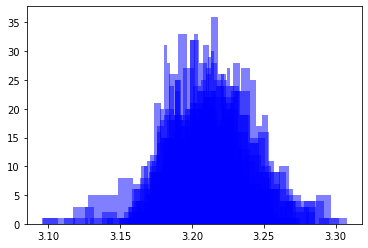

In [5]:
#Search for the variation by determining the rotation period over segments of time via our alt_period_finder algortihm:
sep_midpoints = []
sep_periods = []
sep_errors = []

sample_size = 75
points_per_cycle = 2.5

for i in range(5):
    print("We are now considering the ", names[i], " telescope data")
    alt_comb_midpoints = []
    alt_comb_periods = []
    alt_comb_errors = []
    
    midpoints, chunk_periods, errors = alt_period_finder(times[i], fluxes[i], efluxes[i], sample_size = sample_size, points_per_cycle = points_per_cycle)
    for k in chunk_periods:
        alt_comb_periods.append(k)
    for l in midpoints:
        alt_comb_midpoints.append(l)
    for m in errors:
        alt_comb_errors.append(m)
            
    alt_comb_midpoints = np.array(alt_comb_midpoints)
    alt_comb_periods = np.array(alt_comb_periods)
    alt_comb_errors = np.array(alt_comb_errors).astype(np.float)

    #Remove all periods on the edges or with large errors
    alt_better_mask = (alt_comb_periods < 3.29) * (alt_comb_periods > 3.11) * (alt_comb_errors < 0.05)
    
    print("The amount of sufficiently sampled 75 day segments with a succesfully, low uncertainty determined period is: ", np.sum(alt_better_mask))
    sep_midpoints.append(alt_comb_midpoints[alt_better_mask])
    sep_periods.append(alt_comb_periods[alt_better_mask])
    sep_errors.append(alt_comb_errors[alt_better_mask])
    
print("Please neglect the plot below.")

In [6]:
#Create a nice starting point

x_data = np.concatenate(sep_midpoints)
y_data = np.concatenate(sep_periods)
y_err = np.concatenate(sep_errors)

time_space = np.linspace(np.min(x_data)-100, np.max(x_data)+100, 5000)

x_data, y_data, y_err = zip(*sorted(zip(x_data, y_data, y_err)))
par =    [1950,         56800,       3.2,      0.018] #Guess based on previous results

labels = ["$P_{act}$", "$t_0$", "$P_{mean}$", "$a$"]

In [7]:
#These are handy functions for fitting the activity model to the data retrieved above

def activity_model(t, P, t0, mean, a):
    P_activity = mean + a * np.sin(2*np.pi * (t-t0)/P) 
    return P_activity

def lnlike(theta, t, f, ferr):
    ''' theta holds the free parameters of the model, t,f, ferr are the noisy observed measurements'''
    P, t0, mean, a = theta
    # calculate the model with the values in theta, and the data in (t,f,ferr)
    model = activity_model(t, P, t0, mean, a)
    # calculate the chi squared for each epoch
    chi2 = np.power((f-model)/ferr,2.)
    # add up all the chi squareds, and the -0.5 is for emcee
    return -0.5*(np.sum(chi2))

# prior - here we choose whether to restrict the fitting paramaters
def lnprior(theta):
    P, t0, mean, a = theta
    if 500 < P < 3000 and 3.10 < mean < 3.3:
        return 0.0
    return -np.inf

def lnprob(theta, t, f, ferr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, t, f, ferr)


# this nll function is for the minimise function, which wants a MINIMISE a value, not maximise it.
nll = lambda *args: -lnlike(*args)

In [8]:
#Perform the optimisation
result = op.minimize(nll, par, method='nelder-mead', args=(x_data,y_data,y_err),
                     options={'maxiter':10000,'xtol': 1e-8, 'disp': True})

Optimization terminated successfully.
         Current function value: 11.856872
         Iterations: 200
         Function evaluations: 389


In [9]:
#Create the sampler and run mcmc
ndim, nwalkers = 4, 100

# we can add the parameters found in the LWFIT above:
par = result.x
pos = [par + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x_data,y_data,y_err), threads=4)
pos, prob, state = sampler.run_mcmc(pos, 15000)

burn = 600
samples = sampler.chain[:, burn:, :].reshape((-1, ndim))

In [10]:
#The emcee best fit parameters are:

for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
C:\Users\MasterofAlorgia\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


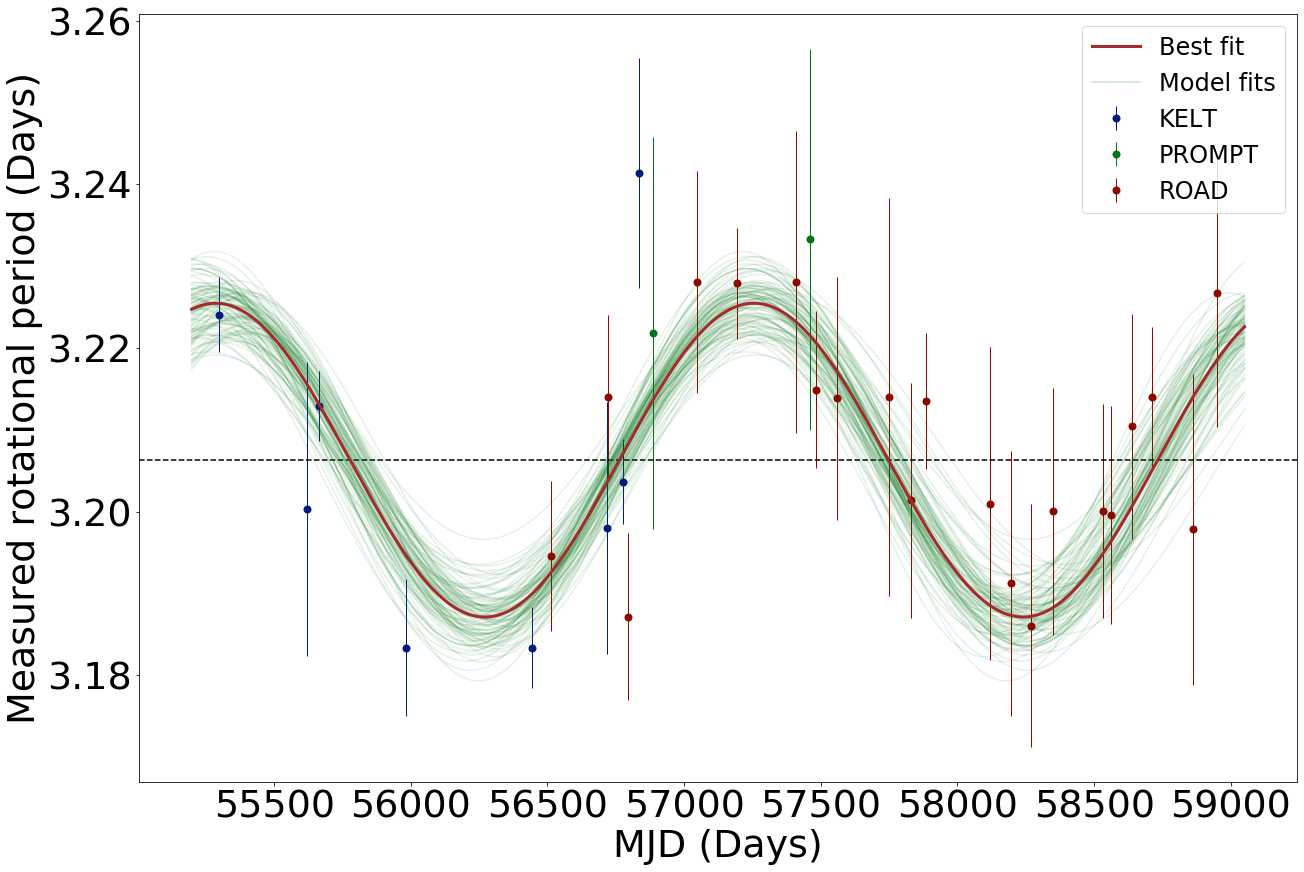

In [11]:
inds = np.random.randint(len(samples), size=100)

font = {'family':'normal', 'weight':'normal', 'size':38}
plt.style.use('seaborn-dark-palette')
plt.rc('font', **font)

fig1, f1a = plt.subplots(ncols=1,nrows=1, figsize=(10,6), constrained_layout=True)

for i in range(5): #[ 2, 4]:
    if i > 1:
        f1a.errorbar(sep_midpoints[i],sep_periods[i],yerr=sep_errors[i],fmt='o',capsize=0 ,mew=3, elinewidth=1,ms=5, label=names[i])

a = np.percentile(samples[:, 0], [50])[0]
b = np.percentile(samples[:, 1], [50])[0]
c = np.percentile(samples[:, 2], [50])[0]
d = np.percentile(samples[:, 3], [50])[0]

a_copy = np.copy(a)
b_copy = np.copy(b)
c_copy = np.copy(c)
d_copy = np.copy(d)

Pact_model = activity_model(time_space, a, b, c, d)    
    
f1a.plot(time_space,Pact_model,'r-', c= 'brown', linewidth=3,zorder=10, label='Best fit')
f1a.axhline(y= np.percentile(samples[:, 2], [50]), linestyle = '--', c='black')

f1a.set_xlabel('MJD (Days)')
f1a.set_ylabel('Measured rotational period (Days)')
for ind in inds:
    onesample = samples[ind]
    P, t0, mean, a = onesample

    # calculate the model with the values in theta, and the data in (t,f,ferr)
    onemodel = activity_model(time_space, P, t0, mean, a) 
    plt.plot(time_space, onemodel, "C1", alpha=0.1)
    if ind == inds[-1]:
        plt.plot(time_space, onemodel, "C1", alpha=0.2, label = 'Model fits')

figure = plt.gcf()
figure.set_size_inches(18, 12)
    
plt.legend(fontsize = 24)
#fig1.savefig('Activity_cycle_30_05.pdf')
plt.show()


## BIC Test

In [12]:
def bic(n, k, data, model, err):
    wlsq = np.sum((data-model)**2/err**2)
    return n*np.log(wlsq/n)+k*np.log(n)

def linear(x, a, b):
    return a*x+b

In [13]:
f_times, f_means, f_errs = np.concatenate(sep_midpoints), np.concatenate(sep_periods), np.concatenate(sep_errors)

lin_popt, pcov = curve_fit(linear, f_times, f_means, p0 = [0, 3.21], sigma=f_errs, absolute_sigma = True)
sine_popt = [a_copy, b_copy, c_copy, d_copy]

n = len(f_times)
k_sine = 4
k_lin = 2

sin_bic = bic(n, k_sine, f_means, activity_model(f_times, *sine_popt), f_errs)
lin_bic = bic(n, k_lin, f_means, linear(f_times, *lin_popt), f_errs)

print("the sinbic is: ", '{0:.2f}'.format(sin_bic))
print("the linbic is: ", '{0:.2f}'.format(lin_bic))

the sinbic is:  5.50
the linbic is:  36.94
